In [58]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import tensorflow as tf

In [59]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"  {gpu}")

    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [60]:
data_path = "/content/combined_dataset-1.xlsx"
df = pd.read_excel(data_path)
df

,Num.,subject_ID,Sex(M/F),Age(year),Height(cm),Weight(kg),Systolic Blood Pressure(mmHg),Diastolic Blood Pressure(mmHg),Heart Rate(b/m),BMI(kg/m^2),...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,1,2,Female,45,152,63,161,89,97,27.268006,...,1766,1766,1766,1833,1833,1827,1827,1827,1754,1754
1,1,2,Female,45,152,63,161,89,97,27.268006,...,1985,1985,2026,2026,2026,1977,1977,1997,1997,1997
2,1,2,Female,45,152,63,161,89,97,27.268006,...,1942,1900,1900,1938,1938,1938,1924,1924,1929,1929
3,2,3,Female,50,157,50,160,93,76,20.284799,...,2073,2072,2072,2072,2051,2051,2036,2036,2036,2045
4,2,3,Female,50,157,50,160,93,76,20.284799,...,2021,2010,2010,2010,2001,2001,2003,2003,2003,1989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652,218,418,Male,25,173,63,106,69,67,21.049818,...,2702,2671,2679,2675,2695,2703,2667,2662,2687,2635
653,218,418,Male,25,173,63,106,69,67,21.049818,...,2391,2362,2378,2363,2323,2355,2355,2395,2362,2367
654,219,419,Male,24,175,58,108,68,65,18.938776,...,2399,2463,2415,2406,2407,2447,2435,2422,2451,2379
655,219,419,Male,24,175,58,108,68,65,18.938776,...,3075,3091,3067,3051,3121,3135,3091,3103,3146,3151


In [61]:
X_raw = df[[str(i) for i in range(1, 2101)]].dropna()
y_sbp = df.loc[X_raw.index, 'Systolic Blood Pressure(mmHg)']
y_dbp = df.loc[X_raw.index, 'Diastolic Blood Pressure(mmHg)']

In [62]:
def sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride):
    X_win, y_win = [], []
    for i in range(len(X_raw)):
        row = X_raw.iloc[i].values
        for start in range(0, 2100 - window_size + 1, stride):
            end = start + window_size
            X_win.append(row[start:end])
            y_win.append([y_sbp.iloc[i], y_dbp.iloc[i]])
    return np.array(X_win), np.array(y_win)

window_size = 200
stride = 200
X_win, y_win = sliding_window_transform(X_raw, y_sbp, y_dbp, window_size, stride)

In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_win.reshape(-1, window_size)).reshape(X_win.shape)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_win, test_size=0.2
)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5256, 200) (1314, 200) (5256, 2) (1314, 2)


----

In [65]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)

    return layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

In [66]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super().__init__()
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def build(self, input_shape):
        position = np.arange(self.sequence_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.embed_dim, 2) * -(np.log(10000.0) / self.embed_dim))

        pos_encoding = np.zeros((self.sequence_length, self.embed_dim))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)

        self.pos_encoding = tf.convert_to_tensor(pos_encoding, dtype=tf.float32)
        self.pos_encoding = self.add_weight(
            name="pos_encoding",
            shape=(1, self.sequence_length, self.embed_dim),
            initializer=tf.initializers.constant(pos_encoding),
            trainable=False,
        )

    def call(self, inputs):
        return inputs + self.pos_encoding

In [67]:
def create_transformer_model(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=4,
    mlp_units=[128, 64],
    dropout=0.2,
    mlp_dropout=0.2,
):
    inputs = layers.Input(shape=input_shape)

    x = layers.Reshape((input_shape[0], 1))(inputs)
    x = layers.Conv1D(filters=head_size * num_heads, kernel_size=1)(x)

    x = PositionalEncoding(sequence_length=input_shape[0], embed_dim=head_size * num_heads)(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(2, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [68]:
def train_bp_model(X_train, y_train, X_val, y_val,
                   window_size=200, batch_size=32,
                   epochs=50) :
    model = create_transformer_model(input_shape=(window_size,))

    model.summary()

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )

    checkpoint = ModelCheckpoint(
        'best_bp_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    return model, history

In [69]:
model, history = train_bp_model(X_train, y_train, X_test, y_test, window_size=window_size)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 200, 1)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 200, 256)  │        512 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 200, 256)  │     51,200 │ conv1d_26[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 256)  │    263,168 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 200, 256)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 200, 256)  │          0 │ positional_encod… │
│                     │                   │            │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 256)  │        512 │ add_40[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 200, 128)  │     32,896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 200, 256)  │     33,024 │ dense_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 200, 256)  │          0 │ dense_51[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 200, 256)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 256)  │        512 │ add_41[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 256)  │    263,168 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 200, 256)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 200, 256)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_70[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 256)  │        512 │ add_42[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 200, 128)  │     32,896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,413,442 (5.39 MB)

 Trainable params: 1,362,242 (5.20 MB)

 Non-trainable params: 51,200 (200.00 KB)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 5483.9688 - mae: 63.1174
Epoch 1: val_loss improved from inf to 282.63965, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 44s 128ms/step - loss: 5466.4805 - mae: 62.9651 - val_loss: 282.6396 - val_mae: 12.6395 - learning_rate: 5.0000e-04
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 483.3575 - mae: 17.0664
Epoch 2: val_loss did not improve from 282.63965
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 483.3210 - mae: 17.0655 - val_loss: 316.6170 - val_mae: 14.1590 - learning_rate: 5.0000e-04
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 465.5953 - mae: 16.6231
Epoch 3: val_loss improved from 282.63965 to 266.01959, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 465.5237 - mae: 16.6216 - val_loss: 266.0196 - val_mae: 12.5983 - learning_rate: 5.0000e-04
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 426.1475 - mae: 15.8933
Epoch 4: val_loss did not improve from 266.01959
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 426.2049 - mae: 15.8944 - val_loss: 266.7898 - val_mae: 12.5561 - learning_rate: 5.0000e-04
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 435.9865 - mae: 16.0445
Epoch 5: val_loss did not improve from 266.01959
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 435.8930 - mae: 16.0423 - val_loss: 270.8094 - val_mae: 12.7402 - learning_rate: 5.0000e-04
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 412.3279 - mae: 15.6969
Epoch 6: val_loss improved from 266.01959 to 265.64459, saving model to best_bp_model.h5


165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 412.2856 - mae: 15.6957 - val_loss: 265.6446 - val_mae: 12.4927 - learning_rate: 5.0000e-04
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 393.4384 - mae: 15.1671
Epoch 7: val_loss did not improve from 265.64459
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 393.4911 - mae: 15.1683 - val_loss: 267.6247 - val_mae: 12.5508 - learning_rate: 5.0000e-04
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 413.9255 - mae: 15.5834
Epoch 8: val_loss did not improve from 265.64459
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 413.9101 - mae: 15.5836 - val_loss: 269.9028 - val_mae: 12.7129 - learning_rate: 5.0000e-04
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 419.9497 - mae: 15.6118
Epoch 9: val_loss did not improve from 265.64459
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 419.9062 - mae: 15.6109 - val_loss: 305.5545 - val_mae: 13.5451 - learning_rate: 5.0000e-04
Epoch 10/50
165/165 ━━━━━━━━━━

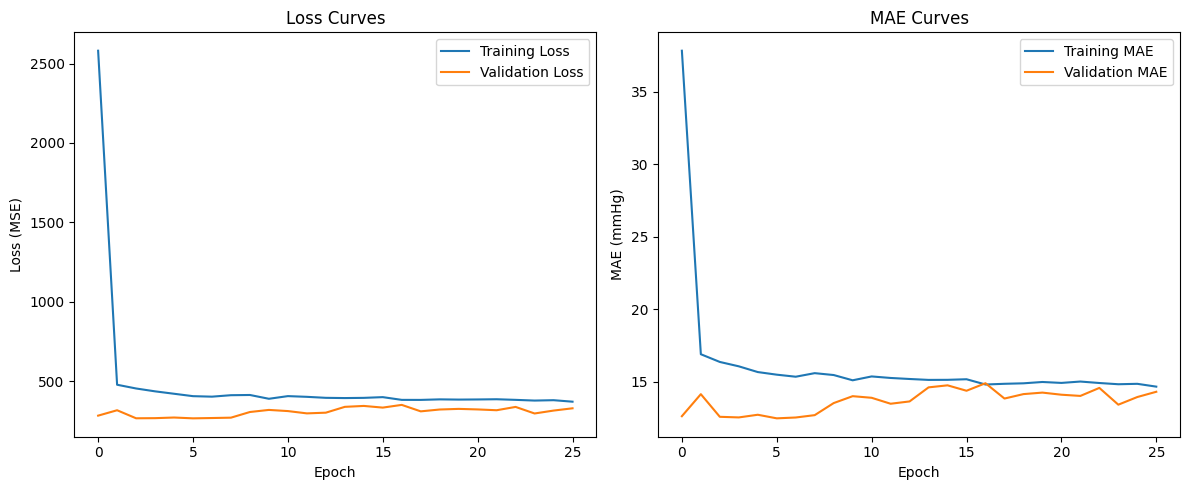

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (mmHg)')
plt.title('MAE Curves')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 268.2597 - mae: 12.4287
Test Loss (MSE): 265.6446
Test MAE: 12.4927


42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step


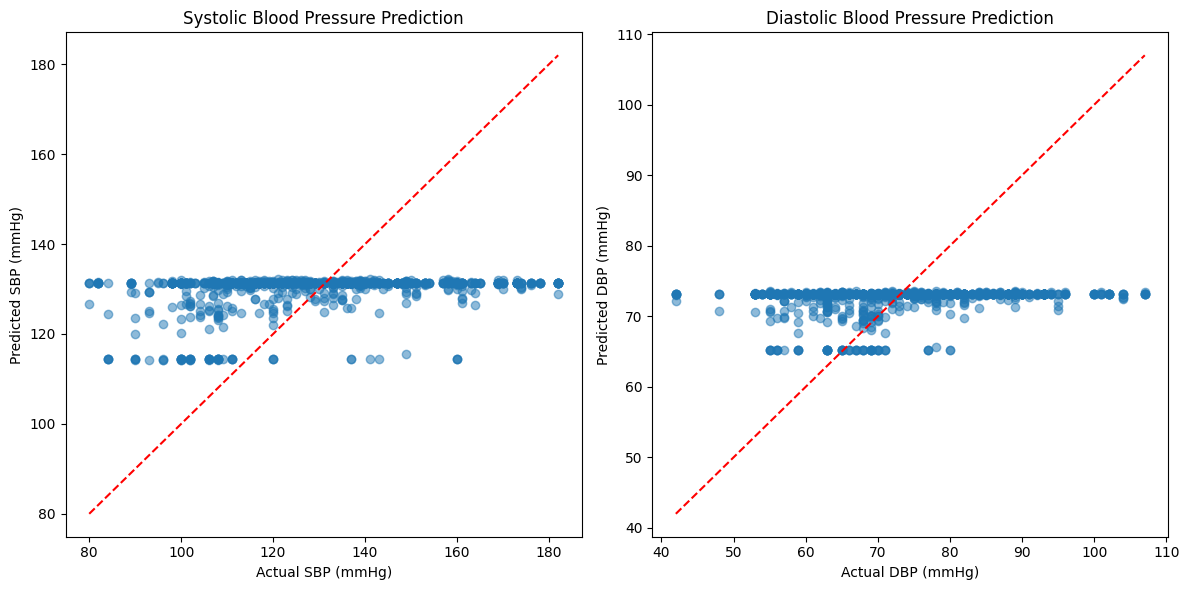

In [72]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5)
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()],
         [y_test[:, 0].min(), y_test[:, 0].max()], 'r--')
plt.xlabel('Actual SBP (mmHg)')
plt.ylabel('Predicted SBP (mmHg)')
plt.title('Systolic Blood Pressure Prediction')

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5)
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()],
         [y_test[:, 1].min(), y_test[:, 1].max()], 'r--')
plt.xlabel('Actual DBP (mmHg)')
plt.ylabel('Predicted DBP (mmHg)')
plt.title('Diastolic Blood Pressure Prediction')

plt.tight_layout()
plt.show()